In [1]:
file = open("/Users/ujandasgupta/Desktop/NLP/CleanData1/corpusFull.txt", "r")

In [2]:
from tqdm import tqdm

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import MinMaxScaler
from collections import defaultdict, Counter
from scipy.sparse import lil_matrix
from sklearn.preprocessing import normalize
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
from tqdm import tqdm

In [4]:
corpus =file.read()

## Step 1: Co-occurrence Matrix

In [5]:
import numpy as np
from collections import defaultdict, Counter
from scipy.sparse import lil_matrix
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

def create_cooccurrence_matrix(corpus, window_size=5, vocab_size=5000):
    # Tokenize and get vocabulary
    words = corpus.split()
    vocab = [word for word, _ in Counter(words).most_common(vocab_size)]
    word2id = {word: i for i, word in enumerate(vocab)}
    
    # Create co-occurrence matrix
    matrix = defaultdict(int)
    for i, word in tqdm(enumerate(words)):
        if word in word2id:
            for j in range(max(0, i - window_size), min(len(words), i + window_size + 1)):
                if i != j and words[j] in word2id:
                    matrix[(word2id[word], word2id[words[j]])] += 1
    # return lil_matrix((vocab_size, vocab_size), dtype=np.float32).todok(), word2id

    return matrix, word2id

matrix, word2id = create_cooccurrence_matrix(corpus)


145386226it [09:26, 256738.37it/s]


In [6]:
coo = [[0 for i in range(5000)] for j in range(5000)]

for i in range(5000):
    for j in range(5000):
        if (i,j) in matrix.keys():
            coo[i][j] += matrix[(i,j)]

In [8]:
matrix = np.array(coo)

## Step 2: Transform to Correlation Matrix

In [10]:
from scipy.sparse import csr_matrix

def compute_correlation(matrix):
    # Convert to a compressed sparse row (CSR) matrix for efficient arithmetic operations
    if not isinstance(matrix, csr_matrix):
        matrix = csr_matrix(matrix)
    
    # Compute the sum of all elements in the matrix for normalization
    total_sum = matrix.sum()
    
    # Compute row sums and column sums
    row_sums = matrix.sum(axis=1)
    col_sums = matrix.sum(axis=0)
    
    # Calculate the joint probability matrix
    joint_prob_matrix = matrix / total_sum
    
    # Calculate the word and context probabilities
    word_prob = row_sums / total_sum
    context_prob = col_sums / total_sum
    
    # Make sure word_prob is a column vector and context_prob is a row vector
    word_prob = np.array(word_prob).flatten()
    context_prob = np.array(context_prob).flatten()
    
    # Calculate the expected values for independent occurrences
    expected_matrix = np.outer(word_prob, context_prob)
    
    # Compute the correlation matrix (element-wise subtraction and division)
    # To avoid division by zero, a small value epsilon is added to the denominator
    epsilon = 1e-10
    numerator = joint_prob_matrix - expected_matrix
    word_prob_std = np.sqrt(word_prob - np.square(word_prob))
    context_prob_std = np.sqrt(context_prob - np.square(context_prob))
    denominator = np.outer(word_prob_std, context_prob_std) + epsilon

    # Flatten the numerator and denominator to perform element-wise division
    numerator = numerator.flatten()
    denominator = denominator.flatten()

    # Reshape the result back to the original matrix shape after division
    correlation_matrix = (numerator / denominator).reshape(matrix.shape)

    # Remove negative values by setting them to zero
    correlation_matrix = np.maximum(correlation_matrix, 0)
    
    return correlation_matrix


In [11]:
matrix = compute_correlation(matrix)


## Step 3: Apply SVD

In [13]:
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize

def apply_svd(matrix, dim=200):
    # Ensure the matrix is a regular NumPy array, not np.matrix
    matrix = np.asarray(matrix)
    
    svd = TruncatedSVD(n_components=dim)
    reduced_matrix = svd.fit_transform(matrix)
    
    # Normalize the reduced matrix
    return normalize(reduced_matrix)

In [14]:
embeddings = apply_svd(matrix)

### Step (a): Identify 5 nouns and generate similar words

In [15]:
def find_similar_words(embedding, word2id, target_word, num_similar=5):
    target_vector = embedding[word2id[target_word]]
    similarities = cosine_similarity(embedding, [target_vector])
    similar_word_indices = similarities[:, 0].argsort()[-num_similar-1:-1][::-1]
    return [list(word2id.keys())[i] for i in similar_word_indices]


In [16]:
nouns = ['football', 'town', 'group', 'singer', 'village']
similar_words_dict = {noun: find_similar_words(embeddings, word2id, noun) for noun in nouns}
print(similar_words_dict)

{'football': ['soccer', 'football.', 'premier', 'nfl.', 'f.c.'], 'town': ['settlement', 'county.', 'village', 'ghost', 'rural'], 'group': ['collective', 'duo', 'group.', 'trio', 'soul'], 'singer': ['musician', 'songwriter', 'composer', 'singersongwriter', 'performer'], 'village': ['municipality', 'town', 'district', 'rural', 'turkey.']}


### Step (b): Choose a word with a good set of similar words

#### Based on the output, let's assume 'group' has a good set of similar words.

### Step (c): Select the top 5 similar words and calculate cosine distance

In [17]:
chosen_word = 'group'
similar_words = find_similar_words(embeddings, word2id, chosen_word, 5)
similarities = cosine_similarity([embeddings[word2id[chosen_word]]], [embeddings[word2id[word]] for word in similar_words])

print(similar_words)
print(similarities[0])


['collective', 'duo', 'group.', 'trio', 'soul']
[0.75352149 0.71967604 0.67446485 0.61803428 0.59739554]


### Step (d): Take the first 200 elements

#### Given the dimension is reduced to 200 using SVD, we already have vectors with 200 elements.

### Step (e): Normalize between [0-255]

In [18]:
def normalize_to_byte_range(vector):
    min_val = np.min(vector)
    return (255.0 * (vector - min_val) / (np.max(vector) - min_val)).astype(int)

normalized_vectors = {word: normalize_to_byte_range(embeddings[word2id[word]]) for word in [chosen_word] + similar_words}


In [19]:
normalized_vectors[chosen_word]

array([126, 255,  77,  54,  71, 144,   7, 110, 103,  86,  81,  70,  84,
        81,  65, 130,  14,  82, 186,  47,  40, 116, 162,   0,  17, 129,
        97,  96,  63, 151,  93, 102,  60,  97,  82, 152,  61, 165,  36,
        45,  22,  82,  96,  60,  86,  31,  84,  94, 117,  34,  84, 137,
        80,  40, 122,  36, 115,  92,  82,  84,  78,  79,  63,  85,  85,
        84,  87, 110,  77,  93,  82, 106, 105,  80,  80,  76,  88,  84,
        91,  75, 121, 109,  83,  58,  88,  66,  99,  83,  76,  79,  72,
        64,  86, 100, 127,  83,  74,  83,  56,  68,  83, 103,  98,  74,
        32,  84,  71, 105,  84,  86,  84, 122,  63,  73,  79,  95,  71,
        86, 105,  88,  95, 171,  86, 106,  84, 118,  67,  54,  24,  54,
        84,  77,  69,  84,  65,  86,  87,  31,  77,  18,  89,  71,  80,
        74,  76,  60,  96,  76,  89,  85,  98, 100,  71,  79,  76, 116,
        84, 104, 105,  81, 140,  70,  73,  93,  65, 120,  65,  89, 100,
        86,  79,  52,  71,  85, 106,  71, 116,  91,  90,  93,  9

### Step (f): Visualization

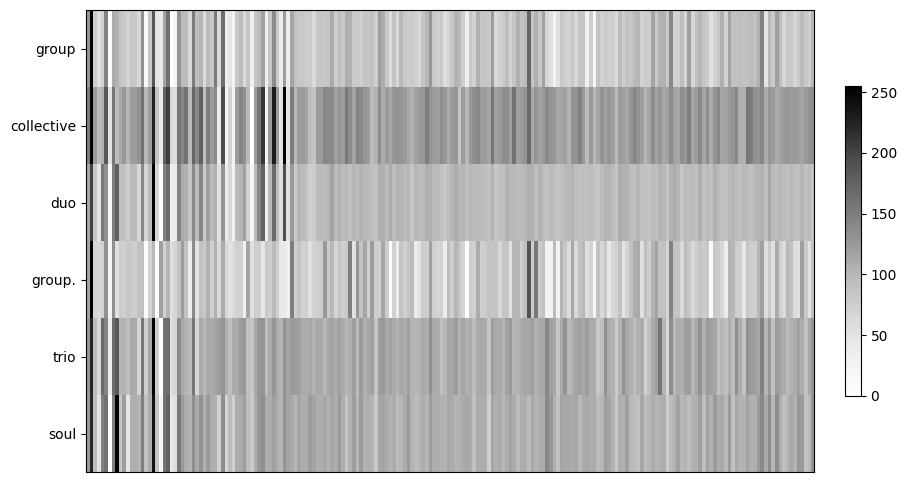

In [25]:
import matplotlib.pyplot as plt
import numpy as np

def plot_similarity_heatmap(normalized_vectors, chosen_word, similar_words):
    # Create a list of the vectors for the chosen word and the similar words
    vectors = [normalized_vectors[chosen_word]] + [normalized_vectors[word] for word in similar_words]
    
    # Stack them into a 2D array where each row is a word vector
    data = np.vstack(vectors)
    
    # Generate the heatmap
    fig, ax = plt.subplots(figsize=(10, len(vectors)))  # Adjust the size as needed
    cax = ax.imshow(data, cmap='Greys', aspect='auto')
    
    # Set the y-axis labels to be the chosen word and the similar words
    labels = [chosen_word] + similar_words
    ax.set_yticks(np.arange(len(labels)))
    ax.set_yticklabels(labels)
    
    # Remove the x-axis labels
    ax.set_xticks([])
    
    # Add a colorbar to show the scale of the values in the heatmap
    plt.colorbar(cax, ax=ax, orientation='vertical', fraction=0.02, pad=0.04)
    
    # Display the plot
    plt.show()

# Assuming 'normalized_vectors' is a dictionary mapping words to their normalized vectors
# and 'chosen_word' is the word of interest with 'similar_words' being a list of words similar to the chosen_word
plot_similarity_heatmap(normalized_vectors, chosen_word, similar_words)
